In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
power_stations = pd.read_csv('../data/power_stations_clean.csv', delimiter=';', encoding='latin1')
Consumption2020_2024 = pd.read_csv('../data/Actual_consumption_202001010000_202405250100_Quarterhour.csv',na_values='-', sep=';', encoding='latin1', thousands=',')
Consumption2015_2020 = pd.read_csv('../data/Actual_consumption_201501010000_202001020100_Quarterhour.csv',na_values='-', delimiter=';', encoding='latin1',thousands=',')
Generation_2020_2024 = pd.read_csv('../data/Actual_generation_202001010000_202405250100_Quarterhour.csv',na_values='-', delimiter=';', encoding='latin1',thousands=',') 
Generation_2015_2020 = pd.read_csv('../data/Actual_generation_201501010000_202001020100_Quarterhour.csv',na_values='-', sep=';', encoding='latin1',thousands=',') 
Cross_Border_2020_2024 = pd.read_csv('../data/Cross-border_physical_flows_202001010000_202405250100_Quarterhour.csv',na_values='-', delimiter=';', encoding='latin1',thousands=',') 
Cross_Border_2015_2020 = pd.read_csv('../data/Cross-border_physical_flows_201501010000_202001020100_Quarterhour.csv',na_values='-', delimiter=';', encoding='latin1',thousands=',') 
Prices_2015_2020 = pd.read_csv('../data/Day-ahead_prices_201501010000_202001020100_Quarterhour.csv', delimiter=';',na_values='-', encoding='utf-8',thousands=',') 
Prices_2020_2024 = pd.read_csv('../data/Day-ahead_prices_202001010000_202405250100_Quarterhour.csv', delimiter=';',na_values='-', encoding='utf-8',thousands=',') 

### Generation_2020_2024

In [3]:
Generation_2020_2024['Start date'] = pd.to_datetime(Generation_2020_2024['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Generation_2020_2024['End date'] = pd.to_datetime(Generation_2020_2024['End date'], format='%b %d, %Y %I:%M %p')
Generation_2020_2024= Generation_2020_2024.drop('ï»¿Start date', axis=1)
Generation_2020_2024 = Generation_2020_2024[['Start date',
 'End date',
 'Biomass [MWh] Original resolutions',
 'Hydropower [MWh] Original resolutions',
 'Wind offshore [MWh] Original resolutions',
 'Wind onshore [MWh] Original resolutions',
 'Photovoltaics [MWh] Original resolutions',
 'Other renewable [MWh] Original resolutions',
 'Nuclear [MWh] Original resolutions',
 'Lignite [MWh] Original resolutions',
 'Hard coal [MWh] Original resolutions',
 'Fossil gas [MWh] Original resolutions',
 'Hydro pumped storage [MWh] Original resolutions',
 'Other conventional [MWh] Original resolutions']]


### Generation_2015_2020

In [4]:
Generation_2015_2020['Start date'] = pd.to_datetime(Generation_2015_2020['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Generation_2015_2020['End date'] = pd.to_datetime(Generation_2015_2020['End date'], format='%b %d, %Y %I:%M %p')
Generation_2015_2020= Generation_2015_2020.drop('ï»¿Start date', axis=1)
Generation_2015_2020 = Generation_2015_2020[['Start date',
 'End date',
 'Biomass [MWh] Original resolutions',
 'Hydropower [MWh] Original resolutions',
 'Wind offshore [MWh] Original resolutions',
 'Wind onshore [MWh] Original resolutions',
 'Photovoltaics [MWh] Original resolutions',
 'Other renewable [MWh] Original resolutions',
 'Nuclear [MWh] Original resolutions',
 'Lignite [MWh] Original resolutions',
 'Hard coal [MWh] Original resolutions',
 'Fossil gas [MWh] Original resolutions',
 'Hydro pumped storage [MWh] Original resolutions',
 'Other conventional [MWh] Original resolutions']]
Generation_2015_2020 = Generation_2015_2020[Generation_2015_2020['End date'] <= '2020-01-01 00:00:00']

### Consumption2015_2020


In [5]:
Consumption2015_2020['Start date'] = pd.to_datetime(Consumption2015_2020['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Consumption2015_2020['End date'] = pd.to_datetime(Consumption2015_2020['End date'], format='%b %d, %Y %I:%M %p')
Consumption2015_2020= Consumption2015_2020.drop('ï»¿Start date', axis=1)
Consumption2015_2020 = Consumption2015_2020[Consumption2015_2020['End date'] <= '2020-01-01 00:00:00']

### Consumption2024_2024

In [6]:
Consumption2020_2024['Start date'] = pd.to_datetime(Consumption2020_2024['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Consumption2020_2024['End date'] = pd.to_datetime(Consumption2020_2024['End date'], format='%b %d, %Y %I:%M %p')
Consumption2020_2024= Consumption2020_2024.drop('ï»¿Start date', axis=1)

### Cross_Boader_2020_2024

In [7]:
Cross_Border_2020_2024['Start date'] = pd.to_datetime(Cross_Border_2020_2024['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Cross_Border_2020_2024['End date'] = pd.to_datetime(Cross_Border_2020_2024['End date'], format='%b %d, %Y %I:%M %p')
Cross_Border_2020_2024= Cross_Border_2020_2024.drop('ï»¿Start date', axis=1)


### Cross_Boader_2015_2020

In [8]:
Cross_Border_2015_2020['Start date'] = pd.to_datetime(Cross_Border_2015_2020['ï»¿Start date'], format='%b %d, %Y %I:%M %p')
Cross_Border_2015_2020['End date'] = pd.to_datetime(Cross_Border_2015_2020['End date'], format='%b %d, %Y %I:%M %p')
Cross_Border_2015_2020= Cross_Border_2015_2020.drop('ï»¿Start date', axis=1)
Cross_Border_2015_2020 = Cross_Border_2015_2020[Cross_Border_2015_2020['End date'] <= '2020-01-01 00:00:00']

### Prices_2015_2020

In [9]:
Prices_2015_2020['Start date'] = pd.to_datetime(Prices_2015_2020['Start date'], format='%b %d, %Y %I:%M %p')
Prices_2015_2020['End date'] = pd.to_datetime(Prices_2015_2020['End date'], format='%b %d, %Y %I:%M %p')
Prices_2015_2020 = Prices_2015_2020[Prices_2015_2020['End date'] <= '2020-01-01 00:00:00']

### Prices_2020_2024

In [10]:
Prices_2020_2024['Start date'] = pd.to_datetime(Prices_2020_2024['Start date'], format='%b %d, %Y %I:%M %p')
Prices_2020_2024['End date'] = pd.to_datetime(Prices_2020_2024['End date'], format='%b %d, %Y %I:%M %p')


#### Concat all to big DataFrames 

In [11]:
Prices = pd.concat([Prices_2015_2020, Prices_2020_2024])
Cross_Border = pd.concat([Cross_Border_2015_2020, Cross_Border_2020_2024])
Consumption = pd.concat([Consumption2015_2020, Consumption2020_2024])
Generation = pd.concat([Generation_2015_2020, Generation_2020_2024])



## EDA

In [12]:
Prices = Prices.reset_index(drop=True)
Cross_Border = Cross_Border.reset_index(drop=True)
Consumption = Consumption.reset_index(drop=True)
Generation = Generation.reset_index(drop=True)

Because there are overlaps between 2015-2020 and 2020-2024

In [13]:
Consumption.drop(index= range(329440, 329472), inplace= True)
Cross_Border.drop(index= range(329440, 329472), inplace= True)
Generation.drop(index= range(329440, 329472), inplace= True)
Prices.drop(index= range(329440, 329472), inplace= True)

In [14]:
# Add sum columns
Cross_Border['Sum [MWh]'] = Cross_Border.loc[:, Cross_Border.columns.difference(['Start date', 'End date','Net export [MWh] Original resolutions'])].sum(axis = 1)
Generation['Sum [MWh]'] = Generation.loc[:, Generation.columns.difference(['Start date', 'End date'])].sum(axis = 1)

In [15]:
# Order the columns

Consumption = Consumption[['Start date','End date',
 'Total (grid load) [MWh] Original resolutions',
 'Residual load [MWh] Original resolutions',
 'Hydro pumped storage [MWh] Original resolutions'
 ]]

In [16]:
Cross_Border = Cross_Border[['Start date','End date',
 'Net export [MWh] Original resolutions',
 'Netherlands (export) [MWh] Original resolutions',
 'Netherlands (import) [MWh] Original resolutions',
 'Switzerland (export) [MWh] Original resolutions',
 'Switzerland (import) [MWh] Original resolutions',
 'Denmark (export) [MWh] Original resolutions',
 'Denmark (import) [MWh] Original resolutions',
 'Czech Republic (export) [MWh] Original resolutions',
 'Czech Republic (import) [MWh] Original resolutions',
 'Luxembourg (export) [MWh] Original resolutions',
 'Luxembourg (import) [MWh] Original resolutions',
 'Sweden (export) [MWh] Original resolutions',
 'Sweden (import) [MWh] Original resolutions',
 'Austria (export) [MWh] Original resolutions',
 'Austria (import) [MWh] Original resolutions',
 'France (export) [MWh] Original resolutions',
 'France (import) [MWh] Original resolutions',
 'Poland (export) [MWh] Original resolutions',
 'Poland (import) [MWh] Original resolutions',
 'Norway (export) [MWh] Original resolutions',
 'Norway (import) [MWh] Original resolutions',
 'Belgium (export) [MWh] Original resolutions',
 'Belgium (import) [MWh] Original resolutions',
 'Sum [MWh]']]

In [17]:
Generation = Generation.drop(Generation.loc[Generation['Start date'].duplicated(keep='first')].index, axis=0)
Consumption = Consumption.drop(Consumption.loc[Consumption['Start date'].duplicated(keep='first')].index, axis=0)
Prices = Prices.drop(Prices.loc[Prices['Start date'].duplicated(keep='first')].index, axis=0)
Cross_Border = Cross_Border.drop(Cross_Border.loc[Cross_Border['Start date'].duplicated(keep='first')].index, axis=0)

### Set the index to the start date 

In [18]:
Consumption = Consumption.set_index('Start date')
Generation = Generation.set_index('Start date')
Cross_Border = Cross_Border.set_index('Start date')
Prices = Prices.set_index('Start date')

Because price data in Germany  begins on 2015-05-01, the data frames are shortened accordingly. 

In [19]:
Consumption.drop(Consumption.loc[Consumption.index < '2015-05-01 00:00:00'].index, inplace= True)
Cross_Border.drop(Cross_Border.loc[Cross_Border.index < '2015-05-01 00:00:00'].index, inplace= True)
Generation.drop(Generation.loc[Generation.index < '2015-05-01 00:00:00'].index, inplace= True)
Prices.drop(Prices.loc[Prices.index < '2015-05-01 00:00:00'].index, inplace= True)

### Check for missing dates in the dataset

In [20]:
first_day_con = Consumption.index.min()
last_day_con = Consumption.index.max()
first_day_pri = Prices.index.min()
last_day_pri = Prices.index.max()
first_day_gen = Generation.index.min()
last_day_gen = Generation.index.max()
first_day_cro = Cross_Border.index.min()
last_day_cro = Cross_Border.index.max()

In [21]:
full_range_con = pd.date_range(start=first_day_con, end=last_day_con, freq="15min")
full_range_pri = pd.date_range(start=first_day_pri, end=last_day_pri, freq="15min")
full_range_gen = pd.date_range(start=first_day_gen, end=last_day_gen, freq="15min")
full_range_cro = pd.date_range(start=first_day_cro, end=last_day_cro, freq="15min")

In [22]:
print(full_range_con.shape)
print(full_range_pri.shape)
print(full_range_gen.shape)
print(full_range_cro.shape)

(317924,)
(317924,)
(317924,)
(317924,)


### Data cleaning Generation

Get an overview

In [23]:
Generation.isna().sum()

End date                                               0
Biomass [MWh] Original resolutions                     0
Hydropower [MWh] Original resolutions                  0
Wind offshore [MWh] Original resolutions               0
Wind onshore [MWh] Original resolutions                1
Photovoltaics [MWh] Original resolutions               0
Other renewable [MWh] Original resolutions             0
Nuclear [MWh] Original resolutions                 11054
Lignite [MWh] Original resolutions                     0
Hard coal [MWh] Original resolutions                   0
Fossil gas [MWh] Original resolutions                  0
Hydro pumped storage [MWh] Original resolutions        1
Other conventional [MWh] Original resolutions          1
Sum [MWh]                                              0
dtype: int64

In [24]:
missing_dates_Generation = full_range_gen.difference(Generation.index)
print(len(missing_dates_Generation))

36


In [25]:
# plt.figure(figsize=(15,8))

# ax = sns.heatmap(Generation.isna().T,cbar=False)
# ax.set(xticklabels=[])

# plt.show()

Nuclear power was shut down in Germany at midnight on 15 April 2023. Nuclear energy was marked as null in the data because it was not clear whether the coalition would decide to reopen the power plants due to the energy crisis in Europe caused by the Russia-Ukraine war. On 30 January 2024, nuclear energy was removed as an energy source from the data and all values are NaN. Therefore the NaN values are replaced by 0.

In [26]:
Generation['Nuclear [MWh] Original resolutions'] = Generation['Nuclear [MWh] Original resolutions'].fillna(0)

In [27]:
d = pd.to_datetime(['2023-04-15 23:30','2023-04-15 23:45', '2023-04-16 00:00','2023-04-16 00:15'])

Generation[Generation.index.isin(d)][['Nuclear [MWh] Original resolutions']]


,Nuclear [MWh] Original resolutions
Start date,
2023-04-15 23:30:00,28.75
2023-04-15 23:45:00,12.75
2023-04-16 00:00:00,0.00
2023-04-16 00:15:00,0.00


In [28]:
Generation[Generation[['Wind onshore [MWh] Original resolutions','Hydro pumped storage [MWh] Original resolutions','Other conventional [MWh] Original resolutions']].isna().any(axis =1)]

,End date,Biomass [MWh] Original resolutions,Hydropower [MWh] Original resolutions,Wind offshore [MWh] Original resolutions,Wind onshore [MWh] Original resolutions,Photovoltaics [MWh] Original resolutions,Other renewable [MWh] Original resolutions,Nuclear [MWh] Original resolutions,Lignite [MWh] Original resolutions,Hard coal [MWh] Original resolutions,Fossil gas [MWh] Original resolutions,Hydro pumped storage [MWh] Original resolutions,Other conventional [MWh] Original resolutions,Sum [MWh]
Start date,,,,,,,,,,,,,,
2024-03-25 15:00:00,2024-03-25 15:15:00,1086.00,420.25,36.75,982.5,6599.0,21.0,0.0,2079.25,590.25,1283.50,15.0,NaN,13113.50
2024-05-24 11:15:00,2024-05-24 11:30:00,1102.75,256.00,6.00,NaN,6827.0,28.0,0.0,2179.75,554.75,1180.75,NaN,195.75,12330.75


the other missing values can only be found in two columns. These are interpolated

In [29]:
Generation = Generation.reindex(full_range_gen)

In [30]:
missing_dates_Generation = full_range_gen.difference(Generation.index)
print(len(missing_dates_Generation))

0


In [31]:
Generation.isna().sum()

End date                                           36
Biomass [MWh] Original resolutions                 36
Hydropower [MWh] Original resolutions              36
Wind offshore [MWh] Original resolutions           36
Wind onshore [MWh] Original resolutions            37
Photovoltaics [MWh] Original resolutions           36
Other renewable [MWh] Original resolutions         36
Nuclear [MWh] Original resolutions                 36
Lignite [MWh] Original resolutions                 36
Hard coal [MWh] Original resolutions               36
Fossil gas [MWh] Original resolutions              36
Hydro pumped storage [MWh] Original resolutions    37
Other conventional [MWh] Original resolutions      37
Sum [MWh]                                          36
dtype: int64

In [32]:
Generation = Generation.interpolate()

In [33]:
Generation.isna().sum().sum()

0

### Data Cleaning Consumption

In [34]:
Consumption.isna().sum()

End date                                           0
Total (grid load) [MWh] Original resolutions       0
Residual load [MWh] Original resolutions           4
Hydro pumped storage [MWh] Original resolutions    1
dtype: int64

In [35]:
missing_dates_Consumption = full_range_con.difference(Consumption.index)
print(len(missing_dates_Consumption))

36


In [36]:
Consumption[Consumption[['Residual load [MWh] Original resolutions','Hydro pumped storage [MWh] Original resolutions']].isna().any(axis =1)]

,End date,Total (grid load) [MWh] Original resolutions,Residual load [MWh] Original resolutions,Hydro pumped storage [MWh] Original resolutions
Start date,,,,
2021-01-06 08:15:00,2021-01-06 08:30:00,15737.75,NaN,61.00
2021-01-06 15:45:00,2021-01-06 16:00:00,16119.00,NaN,3.75
2021-01-06 17:00:00,2021-01-06 17:15:00,16773.00,NaN,1.00
2024-05-24 11:15:00,2024-05-24 11:30:00,13630.00,NaN,NaN


In [37]:
Consumption = Consumption.reindex(full_range_con)

In [38]:
Consumption.isna().sum()

End date                                           36
Total (grid load) [MWh] Original resolutions       36
Residual load [MWh] Original resolutions           40
Hydro pumped storage [MWh] Original resolutions    37
dtype: int64

In [39]:
Consumption = Consumption.interpolate()

In [40]:
Consumption.isna().sum().sum()

0

In [41]:
# plt.figure(figsize=(15,8))

# ax = sns.heatmap(Consumption.isna().T,cbar=False)
# ax.set(xticklabels=[])
# plt.show()

The dataset is complete. Hydro pumped storage and residual load are part of the total grid load.  

### Cross_Border

In [42]:
missing_dates_Cross_Border = full_range_cro.difference(Cross_Border.index)
print(len(missing_dates_Cross_Border))

36


In [43]:
Cross_Border.isna().sum()

End date                                                   0
Net export [MWh] Original resolutions                 191680
Netherlands (export) [MWh] Original resolutions         2258
Netherlands (import) [MWh] Original resolutions         2258
Switzerland (export) [MWh] Original resolutions         2195
Switzerland (import) [MWh] Original resolutions         2195
Denmark (export) [MWh] Original resolutions               44
Denmark (import) [MWh] Original resolutions               44
Czech Republic (export) [MWh] Original resolutions         0
Czech Republic (import) [MWh] Original resolutions         0
Luxembourg (export) [MWh] Original resolutions         77871
Luxembourg (import) [MWh] Original resolutions         77871
Sweden (export) [MWh] Original resolutions                 0
Sweden (import) [MWh] Original resolutions                 0
Austria (export) [MWh] Original resolutions                6
Austria (import) [MWh] Original resolutions                6
France (export) [MWh] Or

In [44]:
# plt.figure(figsize=(15,8))

# ax = sns.heatmap(Cross_Border.isna().T,cbar=False)
# ax.set(xticklabels=[])

# plt.show()

Net Export seems to generate NaN values if the other columns have NaN values. The physical current flow is important for the balance of demand and supply. For this reason, a sum column has already been inserted, which replaces net export and is equivalent if net export has a value. All other values are replaced with 0. net export is removed. 

In [45]:
Cross_Border = Cross_Border.drop('Net export [MWh] Original resolutions', axis =1 )

In [46]:
Cross_Border = Cross_Border.fillna(0)

In [47]:
Cross_Border = Cross_Border.reindex(full_range_cro)

In [48]:
Cross_Border = Cross_Border.interpolate()

In [49]:
Cross_Border.isna().sum().sum()

0

### Prices

In [50]:

missing_dates_Prices = full_range_pri.difference(Prices.index)
print(len(missing_dates_Prices))


36


In [51]:
Prices['Germany/Luxembourg [€/MWh] Calculated resolutions'].isna().sum()

119892

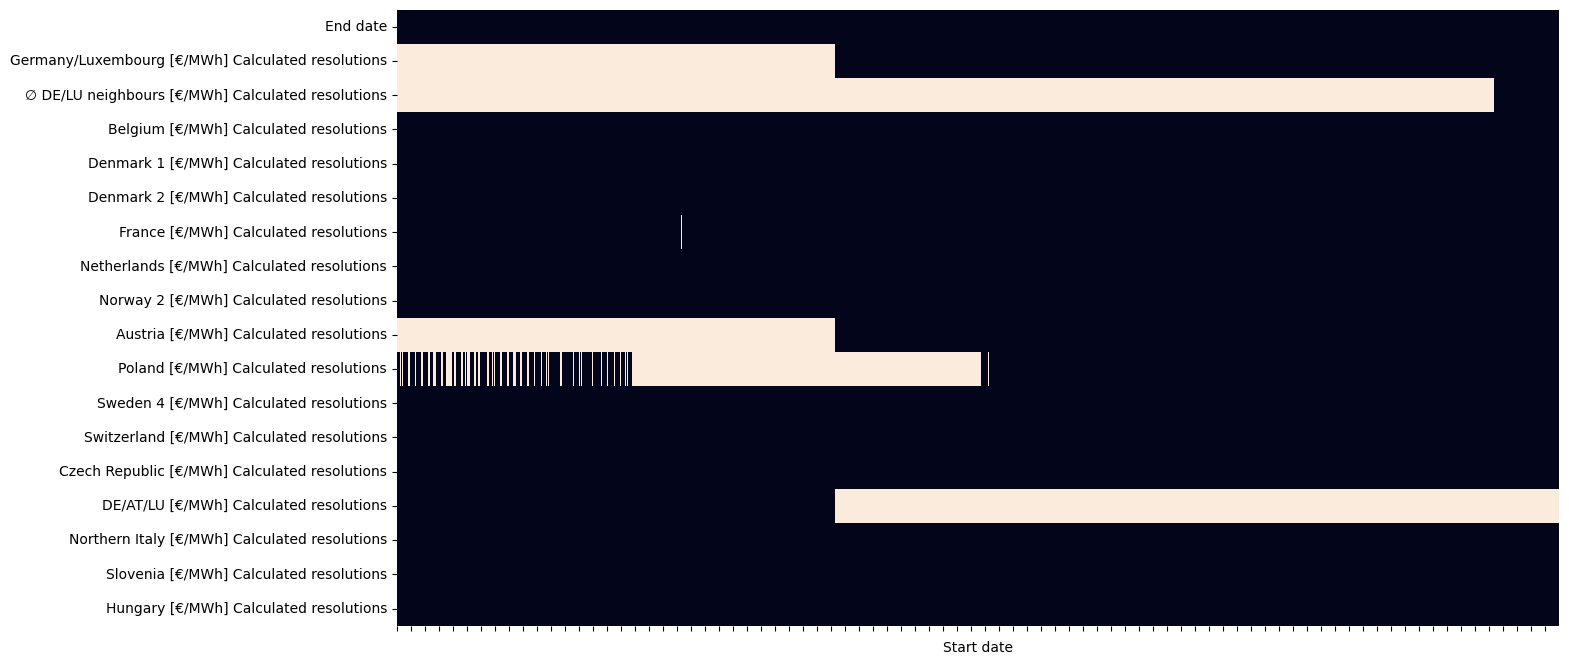

In [52]:
plt.figure(figsize=(15,8))

ax = sns.heatmap(Prices.isna().T,cbar=False)
ax.set(xticklabels=[])
plt.show()

With Prices is less clear. Therefore, the matter is considered in detail below

In [53]:
def list_to_dictionary(list):
    '''
    Example: 
    my_liste = ['Apple', 'Banana', 'Cherry']
    my_dictionary = list_to_dict(my_liste)
    {
        0:Apple,
        1:Banana,
        3:Cherry
    }
    '''
    return {index: x for index, x in enumerate(list)}


We start with Prices 

In [54]:
columns = list_to_dictionary(list(Prices.columns)[1:]) # without Start date and End date 

In [55]:
columns

{0: 'Germany/Luxembourg [€/MWh] Calculated resolutions',
 1: '∅ DE/LU neighbours [€/MWh] Calculated resolutions',
 2: 'Belgium [€/MWh] Calculated resolutions',
 3: 'Denmark 1 [€/MWh] Calculated resolutions',
 4: 'Denmark 2 [€/MWh] Calculated resolutions',
 5: 'France [€/MWh] Calculated resolutions',
 6: 'Netherlands [€/MWh] Calculated resolutions',
 7: 'Norway 2 [€/MWh] Calculated resolutions',
 8: 'Austria [€/MWh] Calculated resolutions',
 9: 'Poland [€/MWh] Calculated resolutions',
 10: 'Sweden 4 [€/MWh] Calculated resolutions',
 11: 'Switzerland [€/MWh] Calculated resolutions',
 12: 'Czech Republic [€/MWh] Calculated resolutions',
 13: 'DE/AT/LU [€/MWh] Calculated resolutions',
 14: 'Northern Italy [€/MWh] Calculated resolutions',
 15: 'Slovenia [€/MWh] Calculated resolutions',
 16: 'Hungary [€/MWh] Calculated resolutions'}

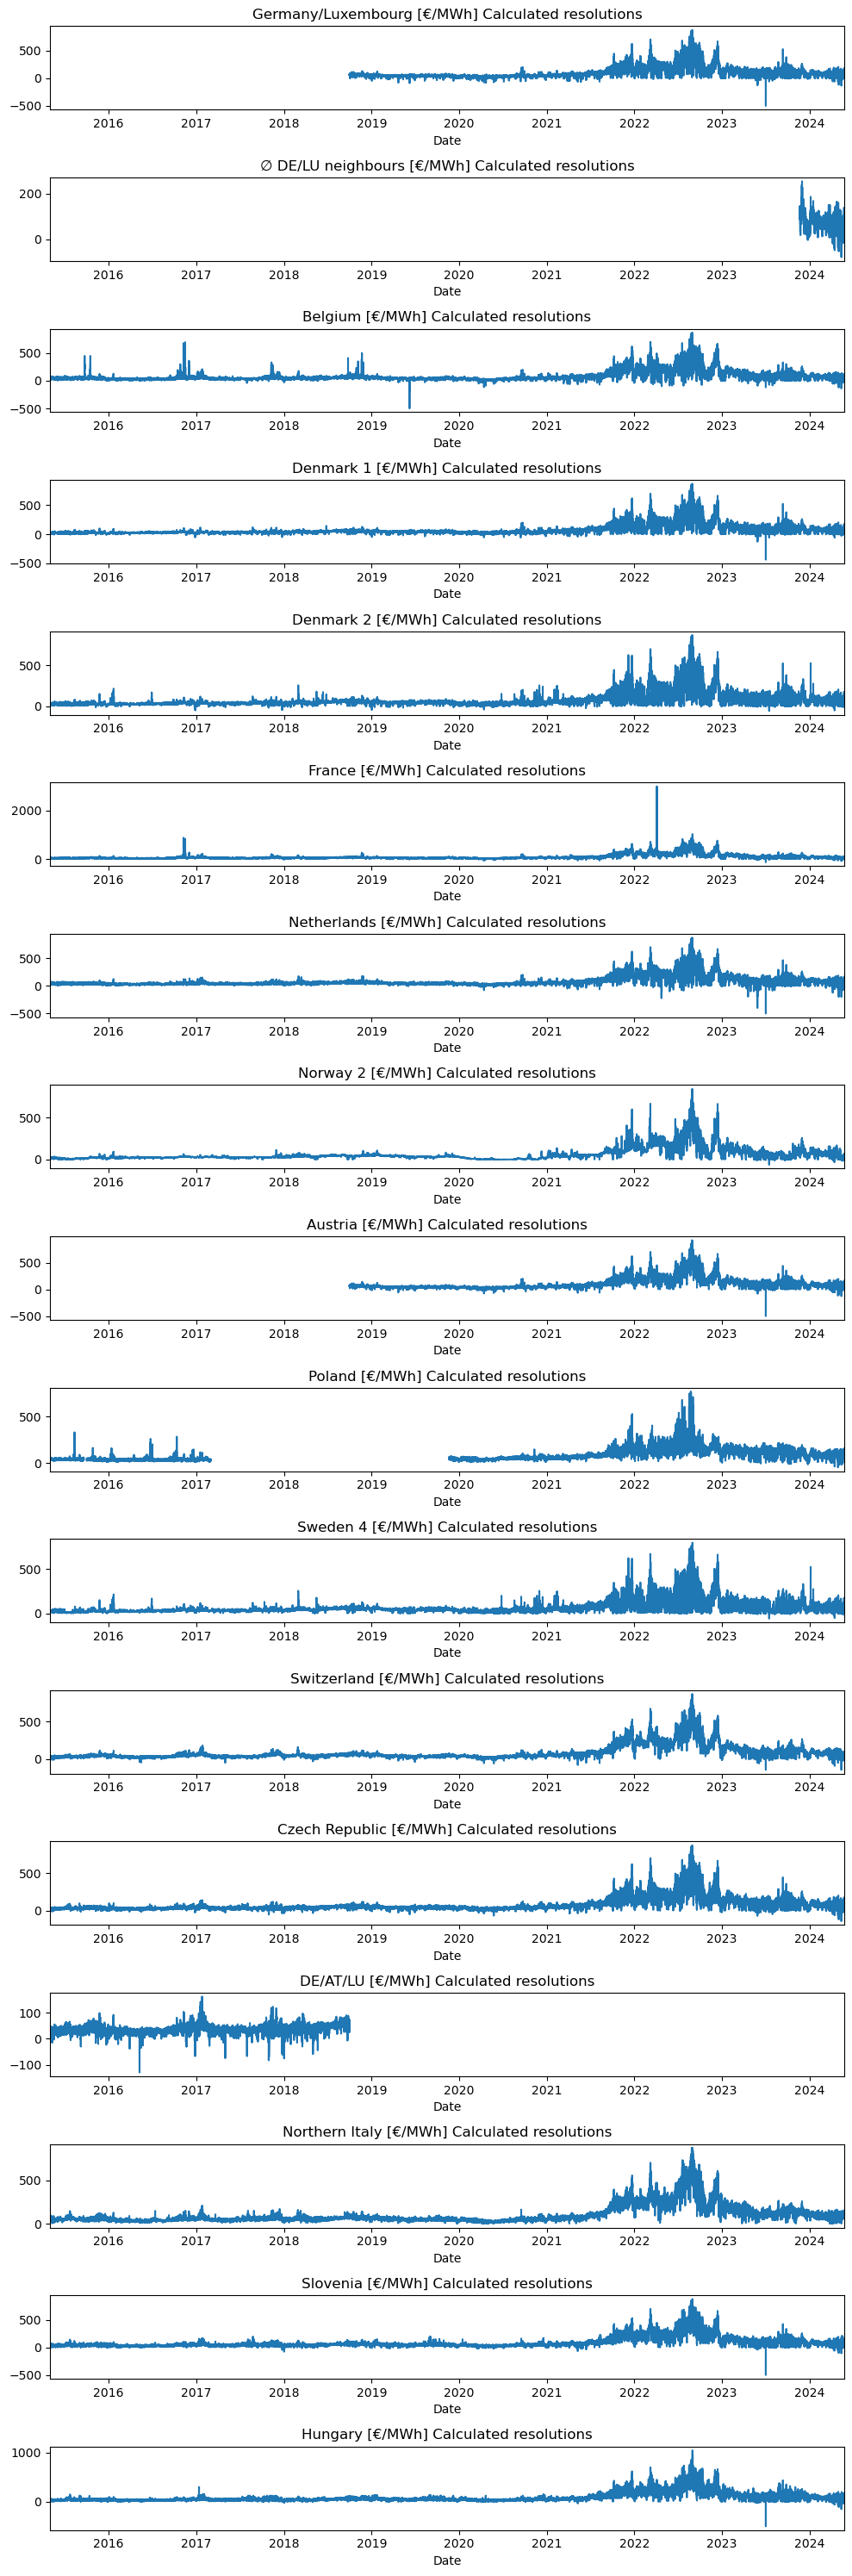

In [56]:


fig = plt.figure(figsize=(10, 30))  # Adjust figure size accordingly
gs = gridspec.GridSpec(17, 1, height_ratios=[1]*17)  # Adjust height_ratios as needed

# Set the common x-axis limits based on the overall data range
x_start = Prices.index.min()
x_end = Prices.index.max()

for k, c in columns.items():
    ax = fig.add_subplot(gs[k])
    ax.plot(Prices.index, Prices[c])
    ax.set_title(c)
    ax.set_xlabel('Date')
    ax.set_xlim([x_start, x_end])  # Set the x-axis limits

plt.tight_layout()
plt.show()

Germany, Luxembourg and Austria initially form a price zone in the data set. This ends and then splits into the Germany/Luxembourg and Austria zones.

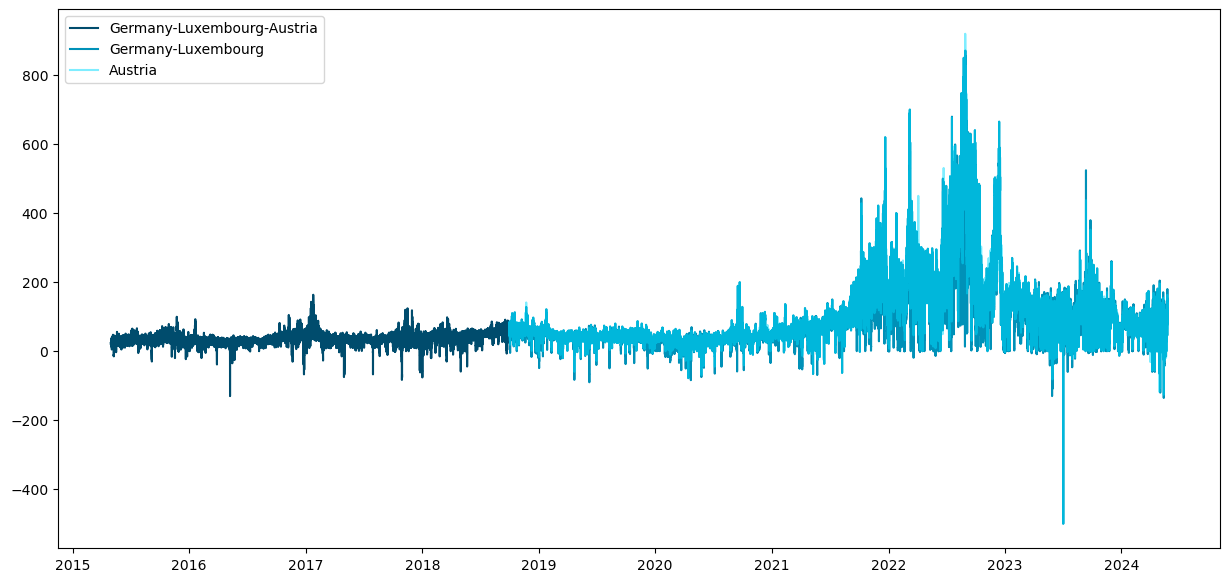

In [57]:
plt.figure(figsize=(15,7))
plt.plot(Prices.index, Prices[columns[13]],color = '#004c6d',label = "Germany-Luxembourg-Austria")
plt.plot(Prices.index, Prices[columns[0]], color ='#0091b8' , label = "Germany-Luxembourg")
plt.plot(Prices.index, Prices[columns[8]], color = '#00ddff', alpha = 0.5,label = "Austria")

plt.legend()
plt.show()

In [58]:
Prices[['DE/AT/LU [€/MWh] Calculated resolutions','Germany/Luxembourg [€/MWh] Calculated resolutions','Austria [€/MWh] Calculated resolutions']].head(385)

,DE/AT/LU [€/MWh] Calculated resolutions,Germany/Luxembourg [€/MWh] Calculated resolutions,Austria [€/MWh] Calculated resolutions
Start date,,,
2015-05-01 00:00:00,24.34,NaN,NaN
2015-05-01 00:15:00,24.34,NaN,NaN
2015-05-01 00:30:00,24.34,NaN,NaN
2015-05-01 00:45:00,24.34,NaN,NaN
2015-05-01 01:00:00,24.09,NaN,NaN
...,...,...,...
2015-05-04 23:00:00,27.19,NaN,NaN
2015-05-04 23:15:00,27.19,NaN,NaN
2015-05-04 23:30:00,27.19,NaN,NaN


The columns complement each other. The split between Germany and Luxembourg on the one side and Austria on the other took place on 30 September 2018. The columns are therefore merged.

In [59]:
Prices['Germany/Luxembourg [€/MWh] Calculated resolutions'] = Prices['Germany/Luxembourg [€/MWh] Calculated resolutions'].fillna(0)+Prices['DE/AT/LU [€/MWh] Calculated resolutions'].fillna(0)
Prices['Austria [€/MWh] Calculated resolutions'] = Prices['Austria [€/MWh] Calculated resolutions'].fillna(0)+Prices['DE/AT/LU [€/MWh] Calculated resolutions'].fillna(0)

In [60]:
#drop the old column DE/AT/LU [€/MWh]
Prices = Prices.drop('DE/AT/LU [€/MWh] Calculated resolutions', axis = 1)

the missing values for Sweden 4 [€/MWh] and Hungary [€/MWh] are replaced by interpolation.

In [61]:
Prices['Hungary [€/MWh] Calculated resolutions'] = Prices['Hungary [€/MWh] Calculated resolutions'].interpolate(method='linear')

In [62]:
Prices['Sweden 4 [€/MWh] Calculated resolutions'] = Prices['Sweden 4 [€/MWh] Calculated resolutions'].interpolate(method='linear')

The column DU/LU neighbours is removed as a column, it is an average.

In [63]:
Prices = Prices.drop('∅ DE/LU neighbours [€/MWh] Calculated resolutions', axis = 1)

In [64]:
Prices = Prices.reindex(full_range_pri)

In [65]:
Prices.isna().sum()

End date                                                 36
Germany/Luxembourg [€/MWh] Calculated resolutions        36
Belgium [€/MWh] Calculated resolutions                   36
Denmark 1 [€/MWh] Calculated resolutions                 36
Denmark 2 [€/MWh] Calculated resolutions                 36
France [€/MWh] Calculated resolutions                   132
Netherlands [€/MWh] Calculated resolutions               36
Norway 2 [€/MWh] Calculated resolutions                  36
Austria [€/MWh] Calculated resolutions                   36
Poland [€/MWh] Calculated resolutions                110636
Sweden 4 [€/MWh] Calculated resolutions                  36
Switzerland [€/MWh] Calculated resolutions              132
Czech Republic [€/MWh] Calculated resolutions            36
Northern Italy [€/MWh] Calculated resolutions            36
Slovenia [€/MWh] Calculated resolutions                  36
Hungary [€/MWh] Calculated resolutions                   36
dtype: int64

to ensure that all border values are filled.

In [66]:
columns_to_fill = Prices.columns.difference(['Poland [€/MWh] Calculated resolutions'])

In [67]:
Prices[columns_to_fill] = Prices[columns_to_fill].interpolate().fillna(method='ffill').fillna(method='bfill')

In [68]:
Prices.isna().sum()

End date                                                  0
Germany/Luxembourg [€/MWh] Calculated resolutions         0
Belgium [€/MWh] Calculated resolutions                    0
Denmark 1 [€/MWh] Calculated resolutions                  0
Denmark 2 [€/MWh] Calculated resolutions                  0
France [€/MWh] Calculated resolutions                     0
Netherlands [€/MWh] Calculated resolutions                0
Norway 2 [€/MWh] Calculated resolutions                   0
Austria [€/MWh] Calculated resolutions                    0
Poland [€/MWh] Calculated resolutions                110636
Sweden 4 [€/MWh] Calculated resolutions                   0
Switzerland [€/MWh] Calculated resolutions                0
Czech Republic [€/MWh] Calculated resolutions             0
Northern Italy [€/MWh] Calculated resolutions             0
Slovenia [€/MWh] Calculated resolutions                   0
Hungary [€/MWh] Calculated resolutions                    0
dtype: int64

First target: Build an model to fil the NaN gaps in Poland prices

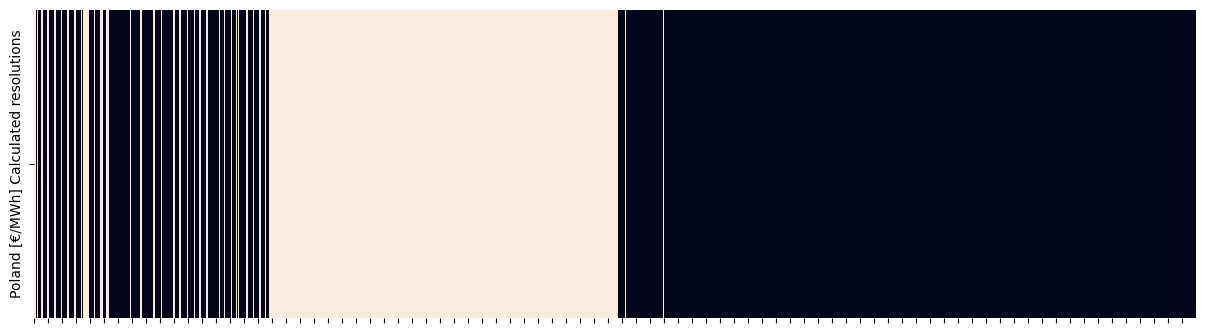

In [69]:
plt.figure(figsize=(15,4))

ax = sns.heatmap(Prices[['Poland [€/MWh] Calculated resolutions']].isna().T,cbar=False)
ax.set(xticklabels=[])
plt.show()

Export

In [70]:
Prices.to_csv('../data/Prices.csv', index= True)
Cross_Border.to_csv('../data/Cross_Border.csv', index= True)
Consumption.to_csv('../data/Cosumption.csv', index= True)
Generation.to_csv('../data/Generation.csv', index= True)

Target results after data-loading: 

- Impact on the price of nuclear phase-out

- Interpolation model for the gaps in the price of Poland 